## data preparation

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

2023-12-03 11:38:32.060099: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 11:38:32.082779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 11:38:32.082799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 11:38:32.082814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 11:38:32.086950: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-03 11:38:33.129967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 11:38:33.134512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 11:38:33.134628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
POINTS_NUM = 3

import numpy as np
points = np.load(f'/host/dissertation/proccessed_data/points_{POINTS_NUM}.npy')
phi = np.load('/host/dissertation/proccessed_data/phi.npy')

In [3]:
import sys
ABS_ROOT_DIR_PATH = '/host/dissertation/'
if ABS_ROOT_DIR_PATH not in sys.path:
    sys.path.append(ABS_ROOT_DIR_PATH)
from common.model import add_custom_objects_to_keras
add_custom_objects_to_keras()

## manual testing

In [28]:
import cvnn.layers as complex_layers

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
# model.add(complex_layers.ComplexDense(units=128, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=16, activation='pol_tanh'))
model.add(complex_layers.ComplexDense(units=16, activation='pol_tanh'))
model.add(complex_layers.ComplexDense(units=1, activation='convert_to_real_with_angle'))
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='angle_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 8)                 64        
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 8)                 144       
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 1)                 18        
 nse)                                                            
                                                                 
Total params: 226 (904.00 Byte)
Trainable params: 226 (904.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
from common.model import FreeMemory
history = model.fit(points, phi, epochs=150, validation_split=0.2, verbose=0, callbacks=[FreeMemory(25)])

epoch 0 ended, info: {'loss': 0.11434105783700943, 'val_loss': 0.03430930897593498}
epoch 25 ended, info: {'loss': 0.007982921786606312, 'val_loss': 0.006499340292066336}
epoch 50 ended, info: {'loss': 0.006642619613558054, 'val_loss': 0.01180095411837101}
epoch 75 ended, info: {'loss': 0.006471952889114618, 'val_loss': 0.007974419742822647}
epoch 100 ended, info: {'loss': 0.0062180194072425365, 'val_loss': 0.009367329068481922}
epoch 125 ended, info: {'loss': 0.006220288574695587, 'val_loss': 0.009197887033224106}


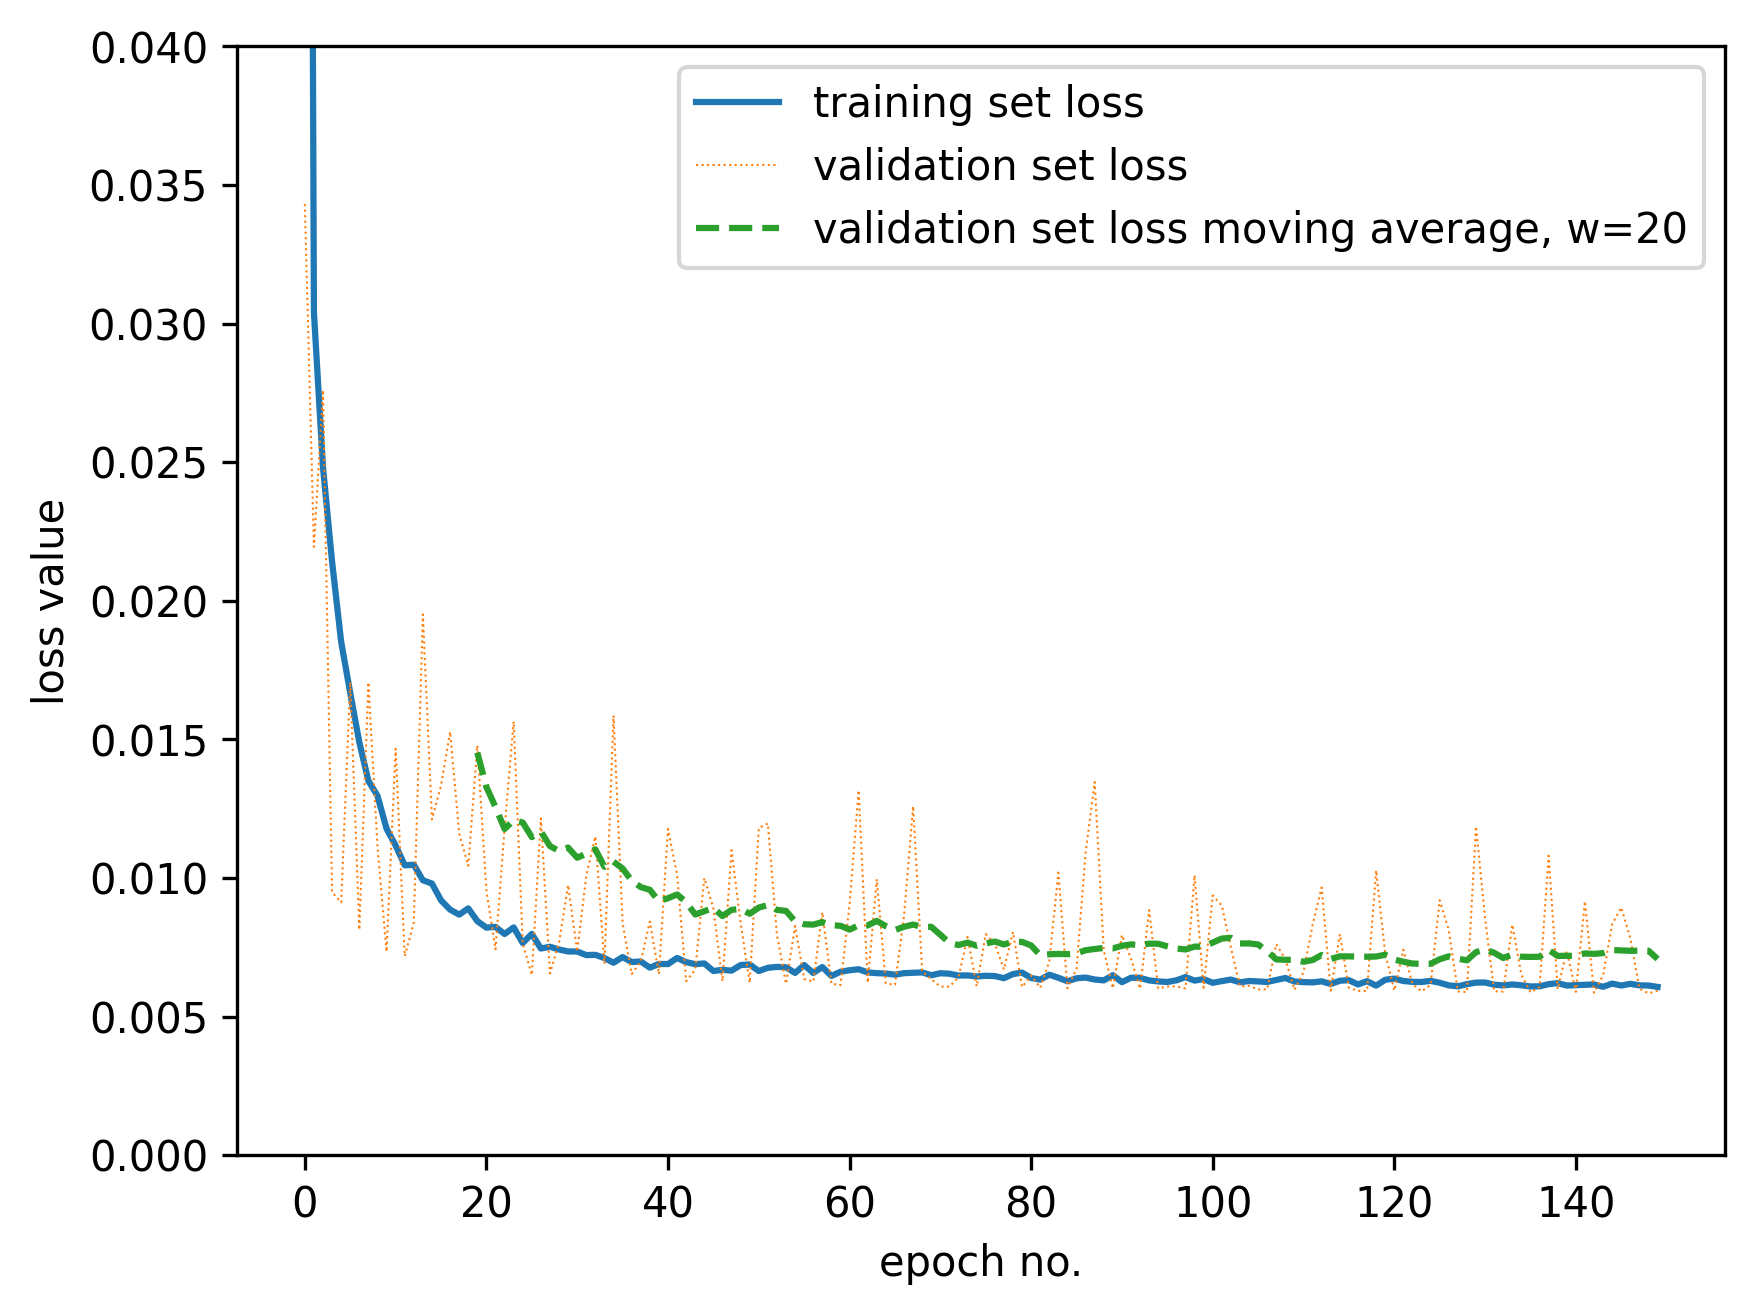

In [48]:
# from common.plot import plot_metric_history
plot_metric_history(history, moving_average_window=(20,), dpi=300, legend_loc = 'upper right', ylim=(0,0.04))

In [83]:
def plot_loss_by_parameter(loss, parameter, loss_label='', parameter_label='', statistic='mean', bins=25, color='#1f77b4', ylim=None, dpi=100):
    from scipy.stats import binned_statistic
    
    bin_means, bin_edges, bin_number = binned_statistic(parameter, loss, statistic=statistic, bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    plt.figure(dpi=dpi)
    plt.plot(parameter, loss, '.', label='loss value', alpha=0.5, color=color)
    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='black', lw=4, label=f'binned {statistic}')
    plt.xlabel(parameter_label)
    plt.ylabel(loss_label)
    plt.grid(linestyle='--', linewidth=0.5) # axis='y', 
    if ylim:
        plt.ylim(ylim)
    xmin, xmax, ymin, ymax = plt.axis()
    print('ylim:', ymin, ymax)
    plt.legend()

 84/256 [========>.....................] - ETA: 0s

256/256 [==============================] - 0s 578us/step
ylim: -0.00254252552986145 0.05340352654457092
ylim: -0.00254252552986145 0.05340352654457092
ylim: -0.00254252552986145 0.05340352654457092
ylim: -0.00254252552986145 0.05340352654457092


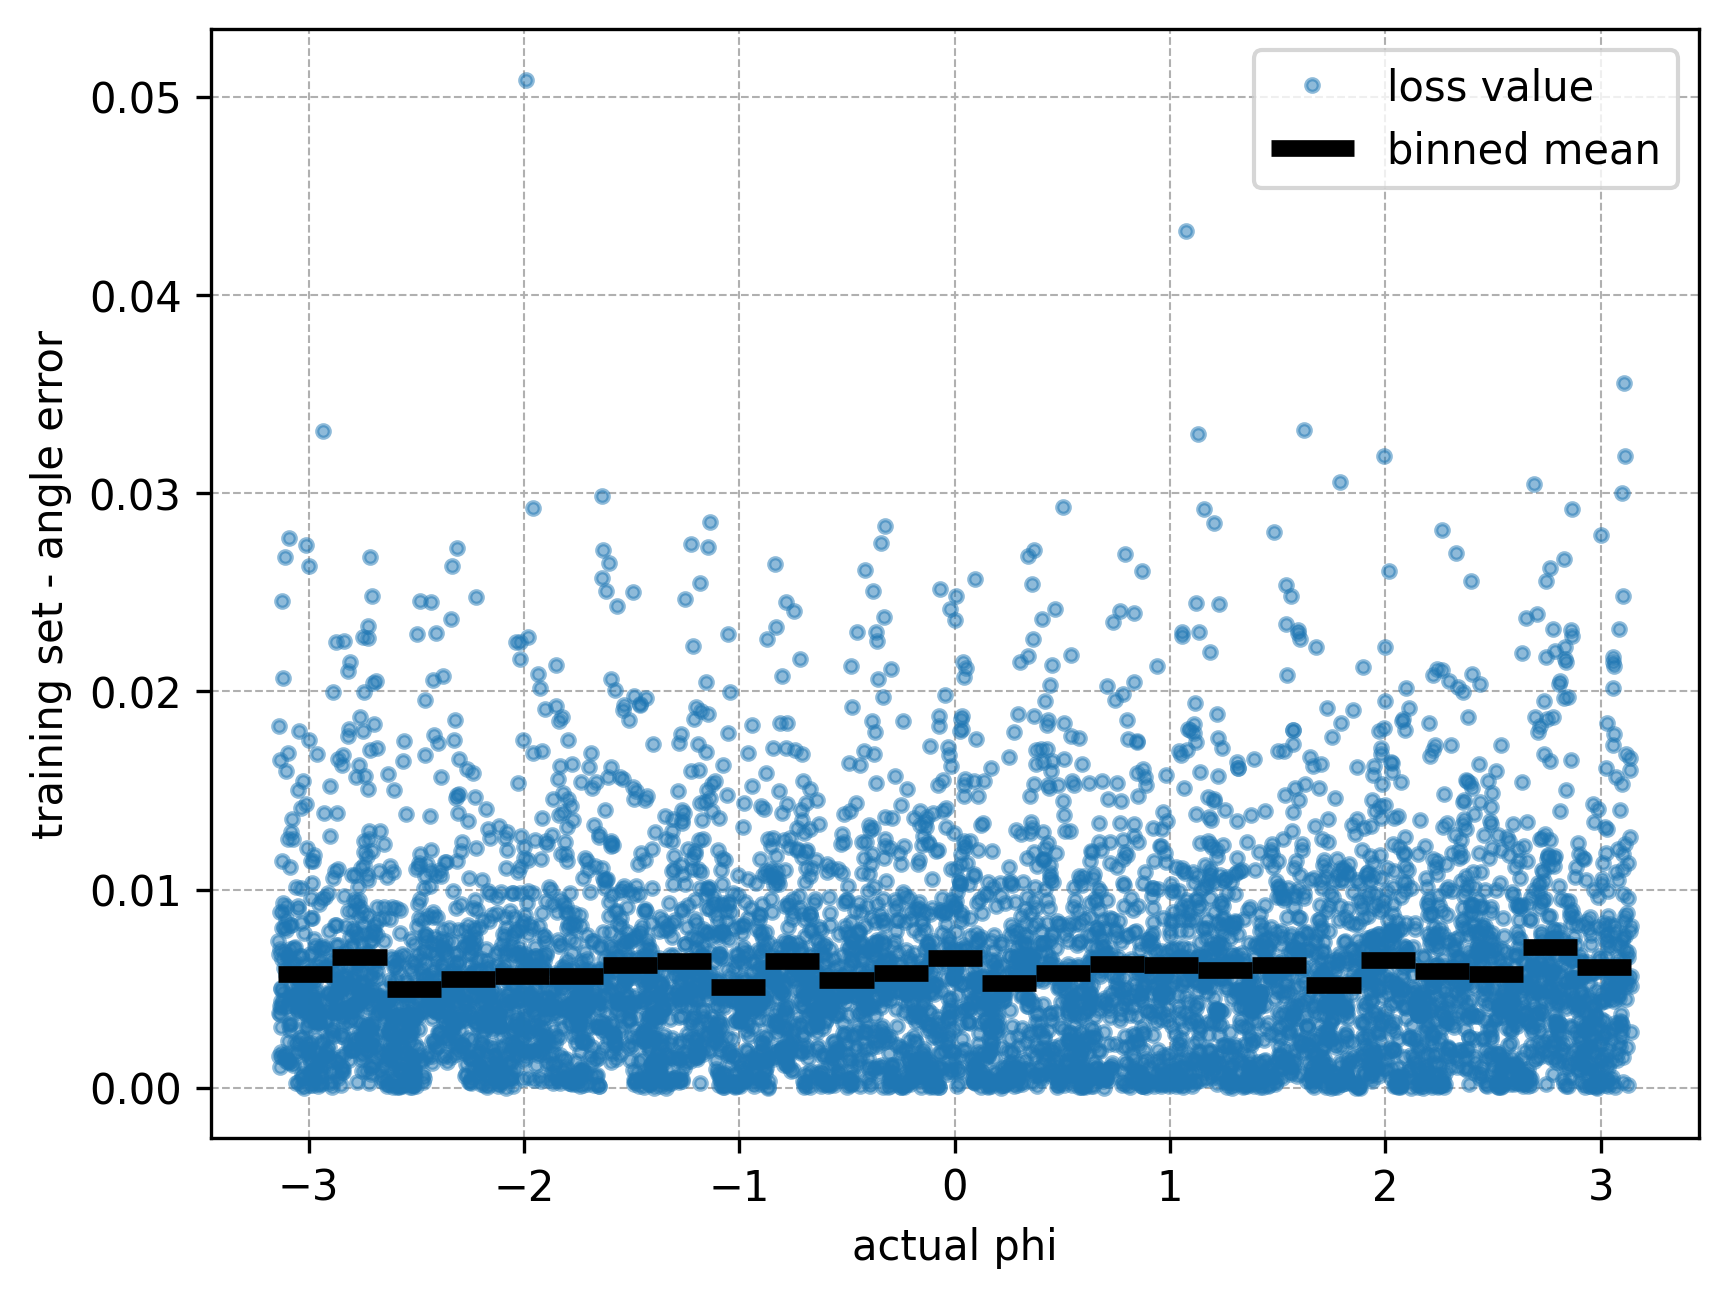

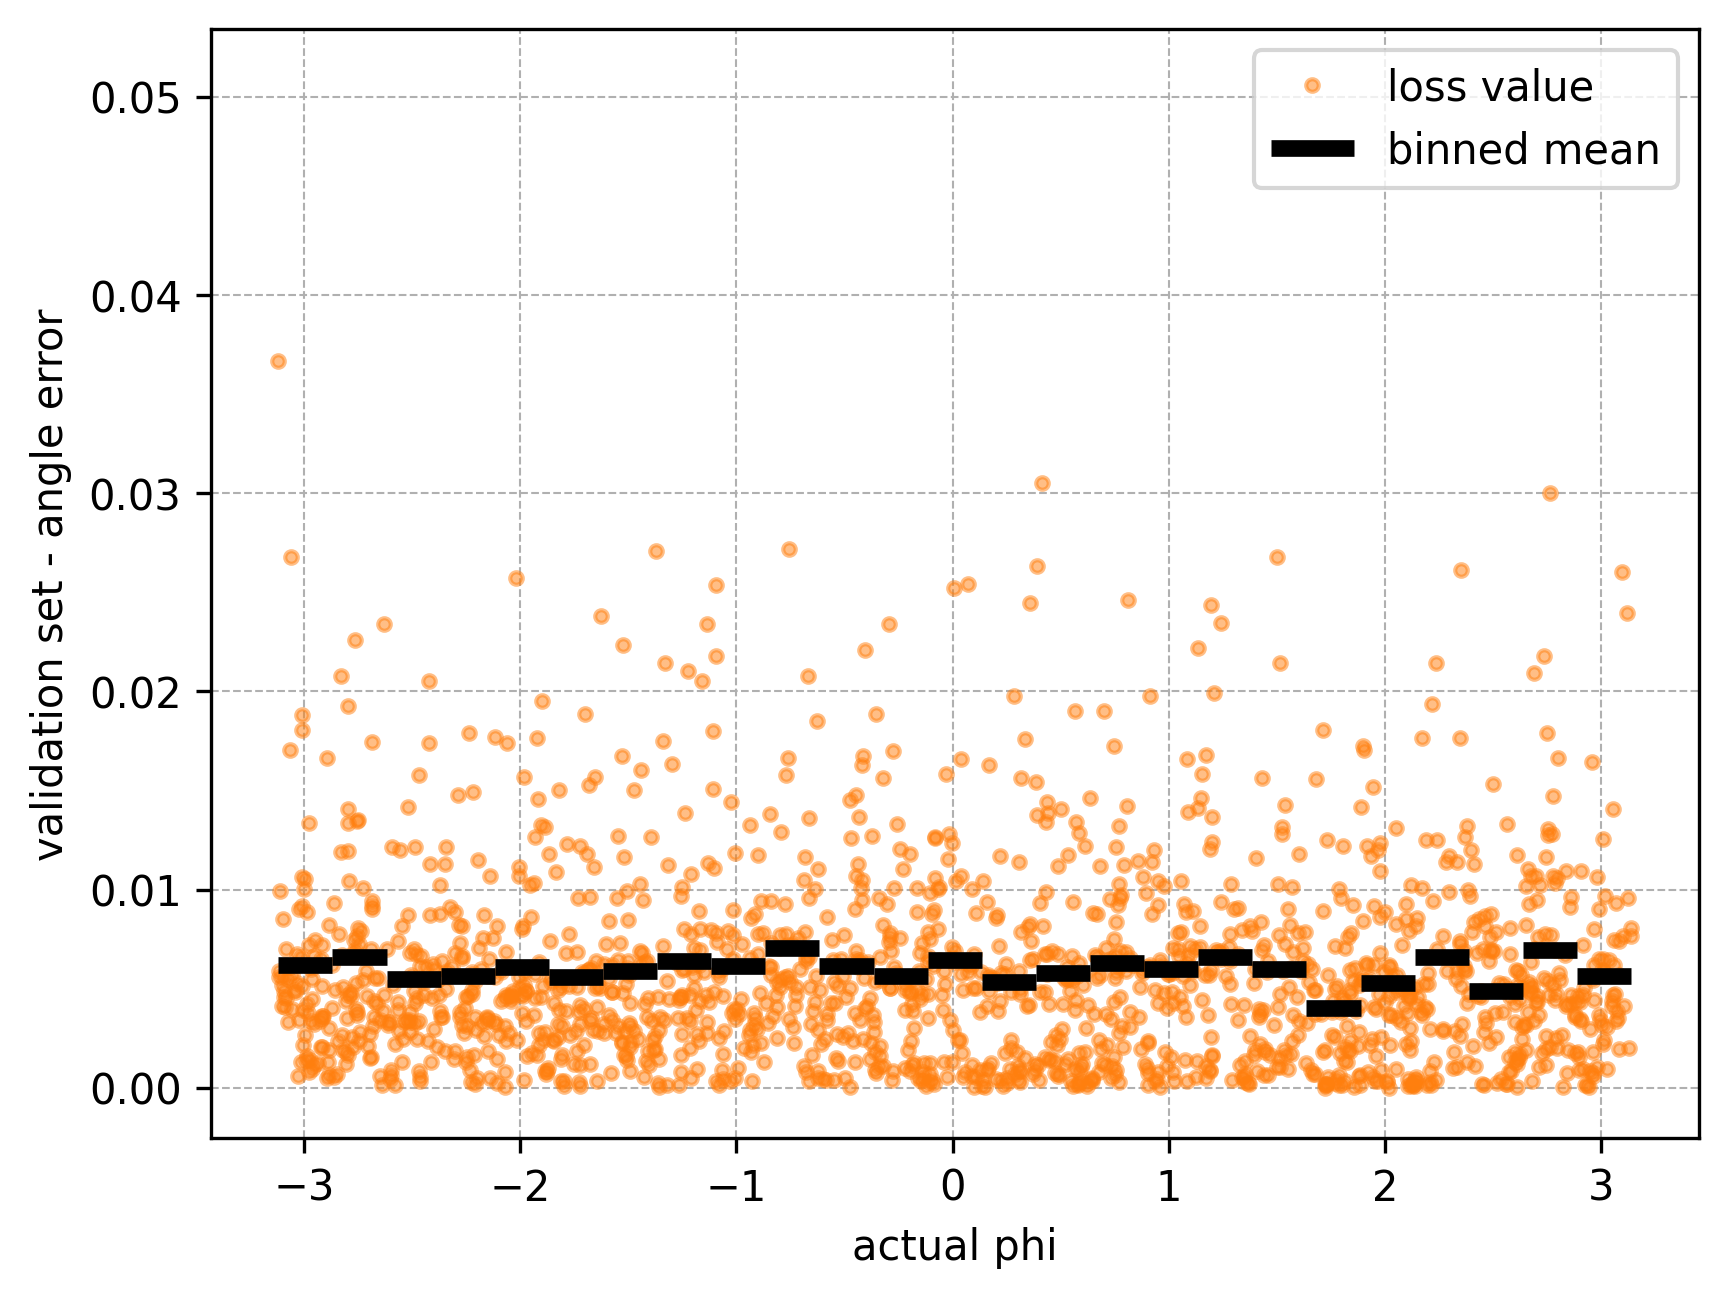

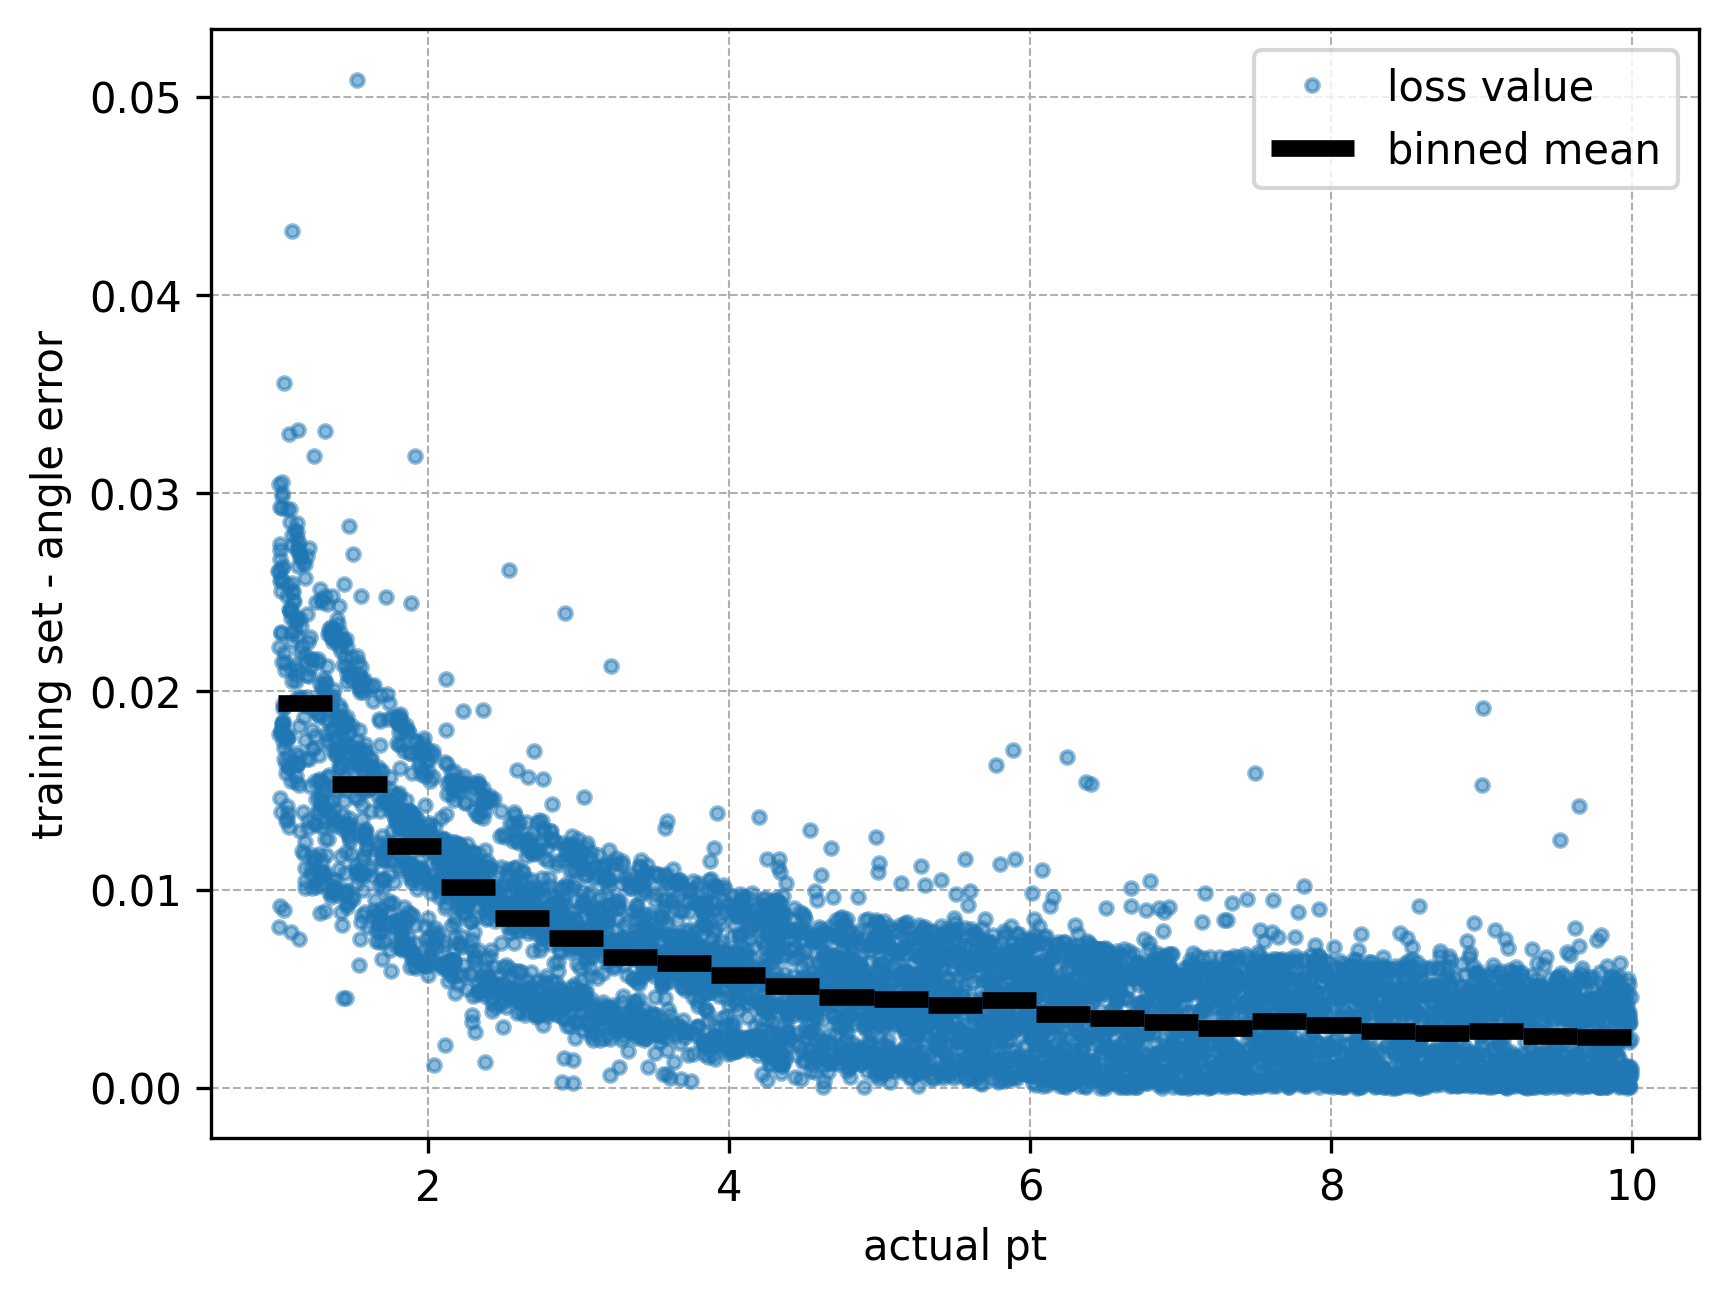

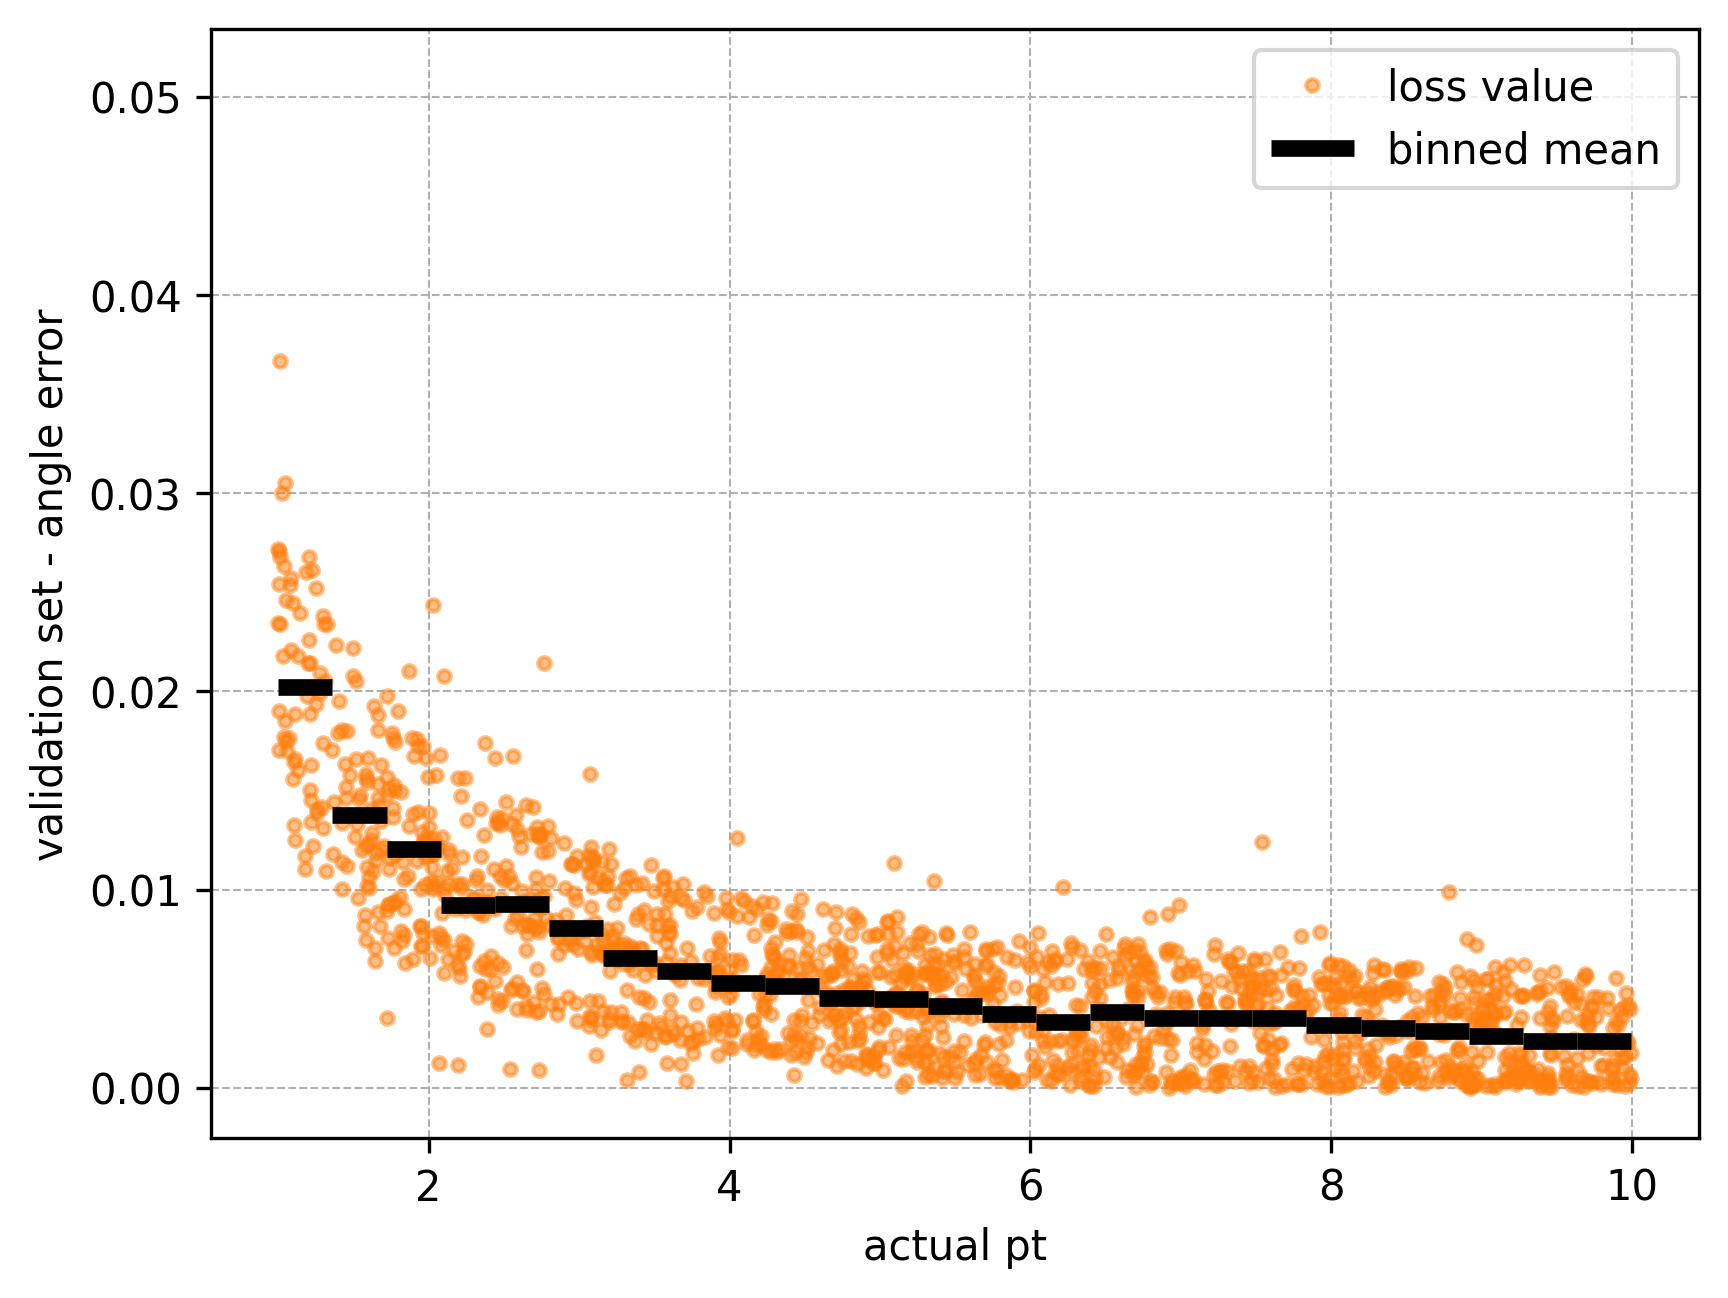

In [90]:
from common.utils import validation_set, train_set
# from common.plot import plot_loss_by_parameter

import tensorflow.math as tf_math
metric = lambda y_true, y_pred: tf_math.abs(tf_math.atan2(tf_math.sin(y_true - y_pred), tf_math.cos(y_true - y_pred)))
result = metric(phi, np.asarray(model.predict(points)).flatten())

ylim=(-0.00254252552986145, 0.05340352654457092)
plot_loss_by_parameter(train_set(result), train_set(phi), 'training set - angle error', 'actual phi', dpi=300, statistic='mean')
plot_loss_by_parameter(validation_set(result), validation_set(phi), 'validation set - angle error', 'actual phi', color='#ff7f0e', ylim=ylim, dpi=300, statistic='mean')

pt = np.load('/host/dissertation/proccessed_data/pt.npy')
plot_loss_by_parameter(train_set(result), train_set(pt), 'training set - angle error', 'actual pt', dpi=300, statistic='mean')
plot_loss_by_parameter(validation_set(result), validation_set(pt), 'validation set - angle error', 'actual pt', color='#ff7f0e', ylim=ylim, dpi=300, statistic='mean')

## space search

In [4]:
from common.search import ConfigsTester
from common.model import convert_to_real_with_angle

configs_tester = ConfigsTester(spacepoints_number_space = [3,10,],
                               hiddenlayers_number_space = [1,2,3,],
                               hiddenlayers_neurons_number_space = [16,64],
                               hiddenlayers_activation_func_space = ['pol_sigmoid','pol_tanh','cart_relu','cart_sigmoid', 'cart_tanh'],
                               outputlayer_activation_func_space = ['convert_to_real_with_angle'],
                               save_path = '/host/dissertation/trained_models/phi/')

In [5]:
from common.model import FreeMemory

configs_tester.test_configs(y_data=phi,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.), 
                            loss='angle_error', 
                            epochs=150, 
                            scenario='150 epochs, pre-search',
                            callbacks=[FreeMemory()])

2023-12-02 11:33:50.716405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 11:33:50.716802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 11:33:50.717070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

START (3, 1, 16, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...


2023-12-02 11:33:53.295062: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe051fb4420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 11:33:53.295075: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-12-02 11:33:53.389024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-12-02 11:33:53.422107: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 16, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 1, 16, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 16, 'pol_tanh', 'convert_to_real_with_angle')
START (3, 1, 16, 'cart_relu', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 16, 'cart_relu', 'convert_to_real_with_angle')
START (3, 1, 16, 'cart_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 16, 'cart_sigmoid', 'convert_to_real_with_angle')
START (3, 1, 16, 'cart_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      

In [8]:
from common.search import ConfigsTester
from common.model import convert_to_real_with_angle

configs_tester = ConfigsTester(spacepoints_number_space = [3,],
                               hiddenlayers_number_space = [1,2,3,],
                               hiddenlayers_neurons_number_space = [16,32,64,128],
                               hiddenlayers_activation_func_space = ['pol_sigmoid','pol_tanh'],
                               outputlayer_activation_func_space = ['convert_to_real_with_angle'],
                               save_path = '/host/dissertation/trained_models/phi/')

In [9]:
from common.model import FreeMemory

configs_tester.test_configs(y_data=phi,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.), 
                            loss='angle_error', 
                            epochs=300, 
                            scenario='300 epochs, search',
                            callbacks=[FreeMemory()])

START (3, 1, 16, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 16, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 1, 16, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 16, 'pol_tanh', 'convert_to_real_with_angle')
START (3, 1, 32, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 32, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 1, 32, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 32, 'pol_tanh', 'convert_to_real_with_angle')
START (3, 1, 64, 'pol_sigmoi

In [4]:
from common.search import ConfigsTester
from common.model import convert_to_real_with_angle

configs_tester = ConfigsTester(spacepoints_number_space = [3,],
                               hiddenlayers_number_space = [1,2,3,4],
                               hiddenlayers_neurons_number_space = [4,8,12,],
                               hiddenlayers_activation_func_space = ['pol_sigmoid','pol_tanh'],
                               outputlayer_activation_func_space = ['convert_to_real_with_angle'],
                               save_path = '/host/dissertation/trained_models/phi/')

In [5]:
from common.model import FreeMemory

configs_tester.test_configs(y_data=phi,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.), 
                            loss='angle_error', 
                            epochs=300, 
                            scenario='300 epochs, 1 hidden layer',
                            callbacks=[FreeMemory()])

2023-12-03 11:38:40.028829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 11:38:40.028939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 11:38:40.028999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

START (3, 1, 4, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...


2023-12-03 11:38:42.599582: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd03caee4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 11:38:42.599593: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-12-03 11:38:42.693756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-12-03 11:38:42.726910: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 4, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 1, 4, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 4, 'pol_tanh', 'convert_to_real_with_angle')
START (3, 1, 8, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 8, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 1, 8, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 8, 'pol_tanh', 'convert_to_real_with_angle')
START (3, 1, 12, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file a

In [8]:
from common.search import ConfigsTester
from common.model import convert_to_real_with_angle

configs_tester = ConfigsTester(spacepoints_number_space = [3,],
                               hiddenlayers_number_space = [0,1],
                               hiddenlayers_neurons_number_space = [1],
                               hiddenlayers_activation_func_space = ['pol_sigmoid','pol_tanh'],
                               outputlayer_activation_func_space = ['convert_to_real_with_angle'],
                               save_path = '/host/dissertation/trained_models/phi/')

In [9]:
from common.model import FreeMemory

configs_tester.test_configs(y_data=phi,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.), 
                            loss='angle_error', 
                            epochs=300, 
                            scenario='300 epochs, 0 hidden layers',
                            callbacks=[FreeMemory()])

START (3, 0, 1, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...


      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 0, 1, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 0, 1, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 0, 1, 'pol_tanh', 'convert_to_real_with_angle')
START (3, 1, 1, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 1, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 1, 1, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 1, 1, 'pol_tanh', 'convert_to_real_with_angle')
